In [1]:
import sys
sys.path.append('../src/')

In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

from torch_geometric import seed_everything

import numpy as np
import pandas as pd

import networkx as nx
from torch_geometric.utils.convert import from_networkx

from tqdm import tqdm

from utils import ws_confusion_matrix, sbm_confusion_matrix, sensitivity_specificity, get_computation_graph_as_nx
from utils import ws_graph_model, sbm_graph_model, deletion_curve_edges, deletion_curve_edges_random
from explainers import gnnexplainer, ig, deconvolution, backprop
from gin import LinkGIN
from gcn import LinkGCN

In [3]:
from matplotlib import pyplot as plt

In [4]:
from utils import area_score, deletion_curve_features, deletion_curve_features_random, normalize_bounds

In [5]:
def train():
    model.train()
    optimizer.zero_grad()

    out = model(train_data.x, train_data.edge_index,
                train_data.edge_label_index)
    loss = F.binary_cross_entropy_with_logits(out, train_data.edge_label)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_label_index).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

graph_model = 'cora'
model_name = 'gin'
explainer = 'ig'
decoder = 'inner'

seed = 0

print(seed)    
seed_everything(seed)

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True),
])

dataset = 'Cora'
path = osp.join('../', 'data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=transform)
train_data, val_data, test_data = dataset[0]

seed_everything(seed)
model = LinkGIN(train_data.num_features, 128, 64, sim=decoder).to(device)
# model = LinkGCN(train_data.num_features, 128, 64, sim=decoder).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

seed_everything(0)
for epoch in range(1, 61):
    loss = train()
    if epoch % 20 == 0:
        val_auc = test(val_data)
        test_auc = test(test_data)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

0
Epoch: 20, Loss: 0.5951, Val: 0.7003, Test: 0.6479
Epoch: 40, Loss: 0.4950, Val: 0.7523, Test: 0.7501
Epoch: 60, Loss: 0.4199, Val: 0.8219, Test: 0.7954


In [9]:
if explainer == 'gnnexplainer':
    binary_threshold = 0.5
if explainer == 'ig':
    binary_threshold = 0.15
if explainer == 'deconvolution':
    binary_threshold = 0.5
if explainer == 'backprop':
    binary_threshold = 0.05

print(binary_threshold)
tpr_tnr_results = []
i = 0
edge_label_index = val_data.edge_label_index[:, [i]]
source_node, target_node = edge_label_index.numpy()[:, 0]

target = val_data.edge_label[i].item()
pred = model(train_data.x, train_data.edge_index, edge_label_index).sigmoid().item()
print(source_node, target_node, pred, target)

0.15
2124 2126 0.9999858140945435 1.0


In [10]:
if explainer == 'gnnexplainer':
    explanation = gnnexplainer(model, train_data.x, train_data.edge_index, edge_label_index, return_type='raw')
if explainer == 'ig':
    explanation = ig(
        model,
        source_node, 
        target_node,
        train_data.x, 
        train_data.edge_index, 
        edge_label_index
    )
if explainer == 'deconvolution':
    explanation = deconvolution(
        model,
        source_node, 
        target_node,
        train_data.x, 
        train_data.edge_index, 
        edge_label_index
    )
if explainer == 'backprop':
    explanation = backprop(
        model,
        source_node, 
        target_node,
        train_data.x, 
        train_data.edge_index, 
        edge_label_index
    )

edge_mask = explanation['edge_mask'].numpy()
node_mask = explanation['node_mask'].numpy()

In [11]:
from torch_geometric.utils import k_hop_subgraph

In [12]:
subset, sub_edge_index, sub_mapping, sub_edge_mask = k_hop_subgraph(
    [source_node, target_node], 
    2, 
    train_data.edge_index)

In [13]:
deletion_curve = deletion_curve_edges(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask]
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 68.95it/s]


In [14]:
rnd_deletion_curves = deletion_curve_edges_random(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask],
    trials=500
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [05:01<00:00,  1.66it/s]


In [15]:
rnd_deletion_curves_mean = np.mean(rnd_deletion_curves, axis=0)

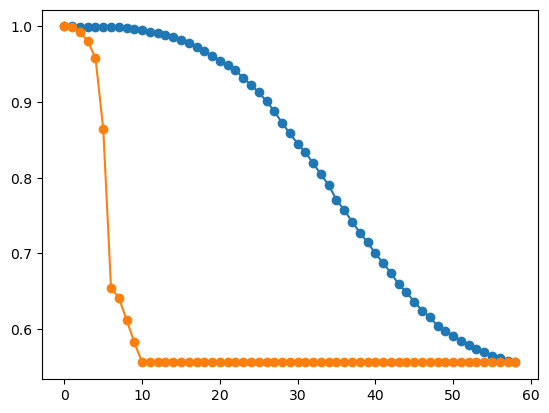

In [16]:
plt.plot(rnd_deletion_curves_mean, marker='o')
plt.plot(deletion_curve, marker='o')

In [17]:
area_score(deletion_curve, rnd_deletion_curves_mean, norm=False)

0.21701871155884303

In [18]:
norm_deletion_curve = normalize_bounds(deletion_curve)
norm_rnd_deletion_curves_mean = normalize_bounds(rnd_deletion_curves_mean)

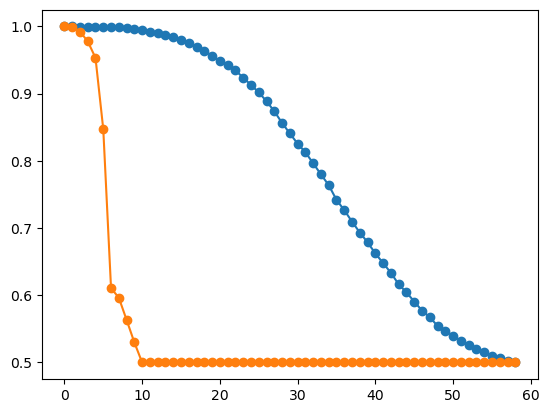

In [19]:
plt.plot(norm_rnd_deletion_curves_mean, marker='o')
plt.plot(norm_deletion_curve, marker='o')

In [20]:
feature_mean_mask = node_mask.mean(axis=0)

In [21]:
node_mean_mask = node_mask.mean(axis=1)

In [22]:
feature_base_values = train_data.x.mean(dim=0)

In [23]:
feature_deletion_curve = deletion_curve_features(
    model,
    train_data.x,
    train_data.edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1433/1433 [00:33<00:00, 42.74it/s]


In [24]:
rnd_feature_deletion_curves = deletion_curve_features_random(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values,
    trials=100
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:01:25<00:00, 36.86s/it]


In [25]:
rnd_feature_deletion_curves_mean = np.mean(rnd_feature_deletion_curves, axis=0)

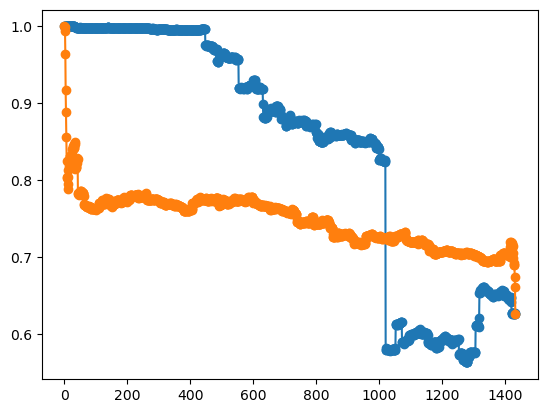

In [26]:
plt.plot(rnd_feature_deletion_curves_mean, marker='o')
plt.plot(feature_deletion_curve, marker='o')

In [27]:
area_score(feature_deletion_curve, rnd_feature_deletion_curves_mean, norm=False)

0.0942743301724124

In [28]:
source_node, target_node

(2124, 2126)

In [29]:
np.argsort(feature_mean_mask)[::-1]

array([ 171, 1241,  533, ...,  357, 1389,  118])

In [30]:
from plotting import visualize_explanation

In [31]:
computation_graph = get_computation_graph_as_nx(source_node, target_node, train_data)

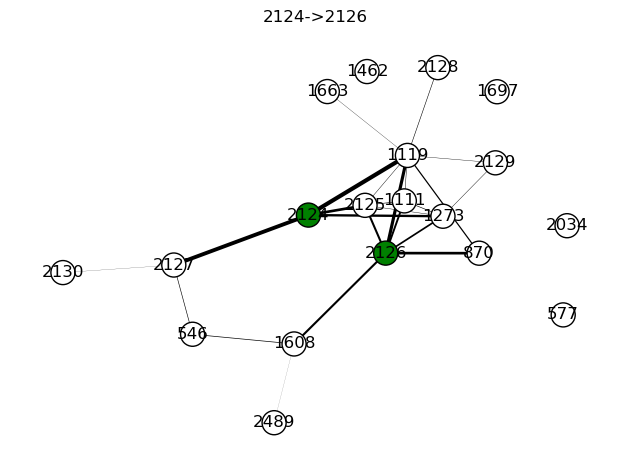

In [32]:
fig = visualize_explanation(computation_graph, train_data.edge_index, edge_mask, source_node, target_node)